In [1]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from pmdarima.arima import ndiffs, nsdiffs 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\alexa\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [4]:
#Series stuff
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [46]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg=None)
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 22:00:00+00:00            0.000000
2016-09-04 23:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.000000
2016-09-05 01:00:00+00:00            0.000000
2016-09-05 02:00:00+00:00            0.000000
2016-09-05 03:00:00+00:00            0.000000
2016-09-05 04:00:00+00:00            0.000000
2016-09-05 05:00:00+00:00            0.000000
2016-09-05 06:00:00+00:00            0.027778
2016-09-05 07:00:00+00:00            0.055556


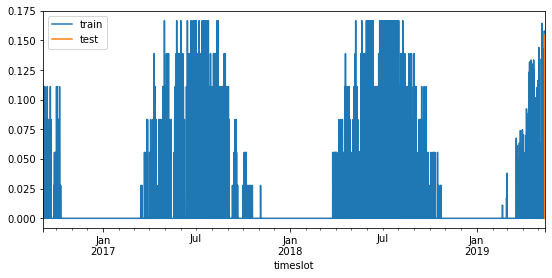

In [17]:
units_to_forecast = 24

train_series = series.copy()
train_series['year']=train_series.index.year
train_series['month']=train_series.index.month
train_series['week']=train_series.index.week
train_series['weekday']=train_series.index.weekday
train_series['hour']=train_series.index.hour

train = train_series[:-units_to_forecast]
test = train_series[-units_to_forecast:]


fig, ax=plt.subplots(figsize=(9, 4))
train['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
ax.legend();

In [23]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
                )

forecaster.fit(y=train['num_kwh_normalized'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 23543] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-10 10:05:34 
Last fit date: 2022-06-10 10:05:43 
Skforecast version: 0.4.3 

Test error (mse): 0.002602717749524175


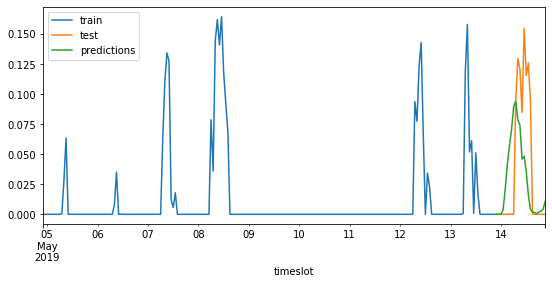

In [24]:
predictions = forecaster.predict(steps=units_to_forecast)

predictions.index = test.index

actual = train_series[-units_to_forecast*10:-units_to_forecast+1]

fig, ax = plt.subplots(figsize=(9, 4))
actual['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

error_mse = mean_squared_error(
                y_true = test['num_kwh_normalized'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

# Hyperparameter tuning

In [38]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1, 2, 3, 12, 24, 48]

# Regressor's hyperparameters
param_grid = {'n_estimators': [i for i in range(50,100,10)],
              'max_depth': [i for i in range(3,10,1)]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_series[:]['num_kwh_normalized'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = units_to_forecast,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)),
                        return_best        = True,
                        fixed_train_size   = True,
                        verbose            = False
               )
results_grid

Number of models compared: 210


loop param_grid:  31%|███████████▎                        | 11/35 [00:08<00:21,  1.12it/s]


loop param_grid:  69%|████████████████████████▋           | 24/35 [00:50<00:30,  2.74s/it]


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [06:12<00:00, 62.10s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 4, 'n_estimators': 70}
  Backtesting metric: 0.0014159284018684045



,lags,params,metric,max_depth,n_estimators
182,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 4, 'n_estimators': 70}",0.001416,4,70
183,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 4, 'n_estimators': 80}",0.001431,4,80
181,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 4, 'n_estimators': 60}",0.001442,4,60
176,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 60}",0.001475,3,60
175,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",0.001475,3,50
...,...,...,...,...,...
26,[1],"{'max_depth': 8, 'n_estimators': 60}",0.004464,8,60
119,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 90}",0.004471,5,90
117,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 70}",0.004474,5,70
118,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 80}",0.004476,5,80


In [65]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[:]['num_kwh_normalized'],
                            initial_train_size = 24*365,
                            steps      = units_to_forecast,
                            refit      = True,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8760
Number of observations used for backtesting: 14808
    Number of folds: 617
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2016-09-04 22:00:00+00:00 -- 2017-09-04 21:00:00+00:00
    Validation: 2017-09-04 22:00:00+00:00 -- 2017-09-05 21:00:00+00:00
Data partition in fold: 1
    Training:   2016-09-05 22:00:00+00:00 -- 2017-09-05 21:00:00+00:00
    Validation: 2017-09-05 22:00:00+00:00 -- 2017-09-06 21:00:00+00:00
Data partition in fold: 2
    Training:   2016-09-06 22:00:00+00:00 -- 2017-09-06 21:00:00+00:00
    Validation: 2017-09-06 22:00:00+00:00 -- 2017-09-07 21:00:00+00:00
Data partition in fold: 3
    Training:   2016-09-07 22:00:00+00:00 -- 2017-09-07 21:00:00+00:00
    Validation: 2017-09-07 22:00:00+00:00 -- 2017-09-08 21:00:00+00:00
Data partition in fold: 4
    Training:   2016-09-08 22:00:00+00:00 -- 2017-09-08 21:00:00+00

    Validation: 2018-08-26 22:00:00+00:00 -- 2018-08-27 21:00:00+00:00
Data partition in fold: 357
    Training:   2017-08-27 22:00:00+00:00 -- 2018-08-27 21:00:00+00:00
    Validation: 2018-08-27 22:00:00+00:00 -- 2018-08-28 21:00:00+00:00
Data partition in fold: 358
    Training:   2017-08-28 22:00:00+00:00 -- 2018-08-28 21:00:00+00:00
    Validation: 2018-08-28 22:00:00+00:00 -- 2018-08-29 21:00:00+00:00
Data partition in fold: 359
    Training:   2017-08-29 22:00:00+00:00 -- 2018-08-29 21:00:00+00:00
    Validation: 2018-08-29 22:00:00+00:00 -- 2018-08-30 21:00:00+00:00
Data partition in fold: 360
    Training:   2017-08-30 22:00:00+00:00 -- 2018-08-30 21:00:00+00:00
    Validation: 2018-08-30 22:00:00+00:00 -- 2018-08-31 21:00:00+00:00
Data partition in fold: 361
    Training:   2017-08-31 22:00:00+00:00 -- 2018-08-31 21:00:00+00:00
    Validation: 2018-08-31 22:00:00+00:00 -- 2018-09-01 21:00:00+00:00
Data partition in fold: 362
    Training:   2017-09-01 22:00:00+00:00 -- 2018-0

KeyboardInterrupt: 

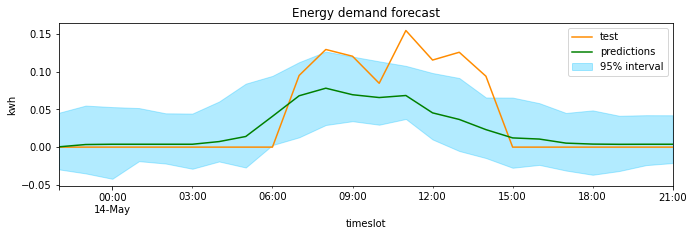

In [44]:
predictions.index = test.index

fig, ax=plt.subplots(figsize=(11, 3))
test['num_kwh_normalized'].plot(ax=ax, label='test', color="darkorange")
predictions['pred'].plot(ax=ax, label='predictions', color="green")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '95% interval'
)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [41]:
error_mse = mean_squared_error(
                y_true = test['num_kwh_normalized'],
                y_pred = predictions['pred']
            )

print(f"Test error (mse): {error_mse}")

inside_interval = np.where(
                     (train_series.loc[predictions.index, 'num_kwh_normalized'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'num_kwh_normalized'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}%")

Test error (mse): 0.0014159284018684045
Coverage of the predicted interval on test data: 70.83333333333334%


# Same shit for consumption

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 22:00:00+00:00            0.000000
2016-09-04 23:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.000000
2016-09-05 01:00:00+00:00            0.000000
2016-09-05 02:00:00+00:00            0.000000
2016-09-05 03:00:00+00:00            0.000000
2016-09-05 04:00:00+00:00            0.000000
2016-09-05 05:00:00+00:00            0.000000
2016-09-05 06:00:00+00:00            0.027778
2016-09-05 07:00:00+00:00            0.055556


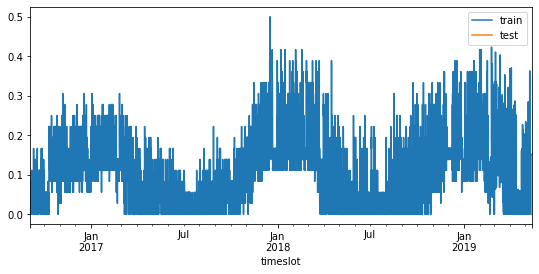

In [47]:
# Cut data to only use the first year
new_series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="cons",
                        start=None,
                        end=None,
                        agg=None)
print(series.head(10))

new_train_series = new_series.copy()
new_train_series['year']=new_train_series.index.year
new_train_series['month']=new_train_series.index.month
new_train_series['week']=new_train_series.index.week
new_train_series['weekday']=new_train_series.index.weekday
new_train_series['hour']=new_train_series.index.hour

new_train = new_train_series[:-units_to_forecast]
new_test = new_train_series[-units_to_forecast:]


fig, ax=plt.subplots(figsize=(9, 4))
new_train['num_kwh_normalized'].plot(ax=ax, label='train')
new_test['num_kwh_normalized'].plot(ax=ax, label='test')
ax.legend();

In [48]:
new_forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
                )

new_forecaster.fit(y=new_train['num_kwh_normalized'])
new_forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 23567] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-10 11:23:03 
Last fit date: 2022-06-10 11:23:27 
Skforecast version: 0.4.3 

Test error (mse): 0.0009022216407761057


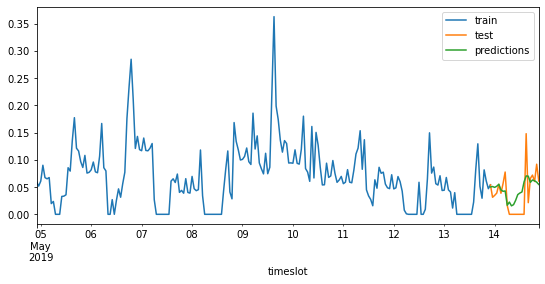

In [50]:
new_predictions = new_forecaster.predict(steps=units_to_forecast)

new_predictions.index = new_test.index

new_actual = new_train_series[-units_to_forecast*10:-units_to_forecast+1]

fig, ax = plt.subplots(figsize=(9, 4))
new_actual['num_kwh_normalized'].plot(ax=ax, label='train')
new_test['num_kwh_normalized'].plot(ax=ax, label='test')
new_predictions.plot(ax=ax, label='predictions')
ax.legend();

new_error_mse = mean_squared_error(
                y_true = new_test['num_kwh_normalized'],
                y_pred = new_predictions
            )

print(f"Test error (mse): {new_error_mse}")

In [51]:
new_forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
new_lags_grid = [1, 2, 3, 12, 24, 48]

# Regressor's hyperparameters
new_param_grid = {'n_estimators': [i for i in range(50,100,10)],
              'max_depth': [i for i in range(3,10,1)]}

new_results_grid = grid_search_forecaster(
                        forecaster         = new_forecaster,
                        y                  = new_train_series[:]['num_kwh_normalized'],
                        param_grid         = new_param_grid,
                        lags_grid          = new_lags_grid,
                        steps              = units_to_forecast,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(new_train)),
                        return_best        = True,
                        fixed_train_size   = True,
                        verbose            = False
               )
new_results_grid

Number of models compared: 210


loop param_grid:  31%|███████████▎                        | 11/35 [00:12<00:27,  1.15s/it]


loop param_grid:  69%|████████████████████████▋           | 24/35 [02:12<01:17,  7.06s/it]


loop lags_grid: 100%|██████████████████████████████████████| 6/6 [15:51<00:00, 158.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 8, 'n_estimators': 70}
  Backtesting metric: 0.0008140138603253727



,lags,params,metric,max_depth,n_estimators
202,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 70}",0.000814,8,70
170,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 50}",0.000828,9,50
203,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 80}",0.000834,8,80
207,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 70}",0.000835,9,70
209,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 9, 'n_estimators': 90}",0.000837,9,90
...,...,...,...,...,...
26,[1],"{'max_depth': 8, 'n_estimators': 60}",0.009480,8,60
67,"[1, 2]","{'max_depth': 9, 'n_estimators': 70}",0.010160,9,70
62,"[1, 2]","{'max_depth': 8, 'n_estimators': 70}",0.010590,8,70
27,[1],"{'max_depth': 8, 'n_estimators': 70}",0.010940,8,70


In [52]:
new_metric, new_predictions = backtesting_forecaster(
                            forecaster = new_forecaster,
                            y          = new_train_series[:]['num_kwh_normalized'],
                            initial_train_size = len(new_train),
                            steps      = units_to_forecast,
                            refit      = False,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
new_predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 23568
Number of observations used for backtesting: 24
    Number of folds: 1
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2016-09-03 22:00:00+00:00 -- 2019-05-13 21:00:00+00:00
    Validation: 2019-05-13 22:00:00+00:00 -- 2019-05-14 21:00:00+00:00



,pred,lower_bound,upper_bound
timeslot,,,
2019-05-13 22:00:00+00:00,0.000398,-0.029542,0.045600
2019-05-13 23:00:00+00:00,0.003444,-0.034890,0.055115
2019-05-14 00:00:00+00:00,0.003824,-0.042016,0.053125
2019-05-14 01:00:00+00:00,0.003824,-0.018638,0.051818


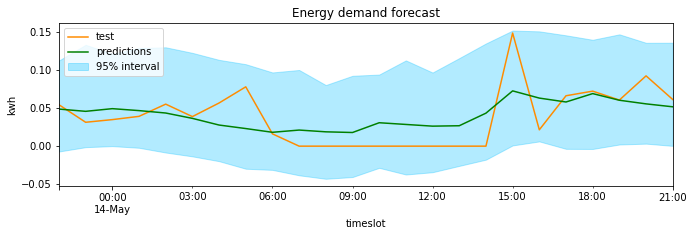

In [53]:
new_predictions.index = new_test.index

fig, ax=plt.subplots(figsize=(11, 3))
new_test['num_kwh_normalized'].plot(ax=ax, label='test', color="darkorange")
new_predictions['pred'].plot(ax=ax, label='predictions', color="green")
ax.fill_between(
    new_predictions.index,
    new_predictions['lower_bound'],
    new_predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '95% interval'
)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [55]:
new_error_mse = mean_squared_error(
                y_true = new_test['num_kwh_normalized'],
                y_pred = new_predictions['pred']
            )

print(f"Test error (mse): {new_error_mse}")

new_inside_interval = np.where(
                     (new_train_series.loc[predictions.index, 'num_kwh_normalized'] >= new_predictions['lower_bound']) & \
                     (new_train_series.loc[predictions.index, 'num_kwh_normalized'] <= new_predictions['upper_bound']),
                     True,
                     False
                  )

new_coverage = new_inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * new_coverage}%")

Test error (mse): 0.0008140138603253727
Coverage of the predicted interval on test data: 100.0%
